# C√†i ƒë·∫∑t YOLOv2

Ngu·ªìn tham kh·∫£o:
- https://www.kaggle.com/trungthanhnguyen0502/yolo-v2-from-scratch/notebook
- https://www.maskaravivek.com/post/yolov2/


### Outline:
0. Chu·∫©n b·ªã d·ªØ li·ªáu
1. Anchor box clustering v·ªõi thu·∫≠t to√°n K-Means
2. X·ª≠ l√Ω Input v√† Label
3. L·ªõp MyGenerator
4. Ki·∫øn tr√∫c m√¥ h√¨nh
5. H√†m loss
6. Training

<a id='a'></a>
## 0. Chu·∫©n b·ªã d·ªØ li·ªáu

Ta s·∫Ω s·ª≠ d·ª•ng t·∫≠p d·ªØ li·ªáu <a href="http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#data">**Pascal VOC 2012**</a>
  

In [1]:
CLASSES = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle',
           'bus',        'car',      'cat',  'chair',     'cow',
           'diningtable', 'dog',    'horse',  'motorbike', 'person',
           'pottedplant', 'sheep',  'sofa',   'train',   'tvmonitor']

In [2]:
imgs_folder = "VOC2012/JPEGImages/"
anns_folder = "VOC2012/Annotations/"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
%matplotlib inline

C√°c annotations g·ªëc ƒëang ·ªü d·∫°ng XML n√™n ta s·∫Ω ƒë·ªçc ch√∫ng l√† l∆∞u v√†o 1 dictionary.

In [4]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, classes):
    '''
    Argments:
        `ann_dir`: annotations folder
        `img_dir`: images folder
    Return:
        `all_anns`: dictionary of image annotations (1 annotation per image)
        `class_counts`: dictionary (class, the number of obj found)    
    '''
    all_anns = []
    class_counts = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        tree = ET.parse(ann_dir + ann)

        img = {'object':[]}
        
        for ele in tree.iter():
            if 'filename' in ele.tag:
                path_to_image = img_dir + ele.text
                img['filename'] = path_to_image
                # If this image doesn't exist, raise an exception
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)

            # width and height of image
            if 'width' in ele.tag:
                img['width'] = int(ele.text)

            if 'height' in ele.tag:
                img['height'] = int(ele.text)

            # bounding box information: class and coordinates
            if 'object' in ele.tag or 'part' in ele.tag:
                obj = {}
                
                for attr in list(ele):
                    if 'name' in attr.tag:
                        # class
                        obj['name'] = attr.text
                        
                        # If this class is not in CLASSES, skip this element
                        if obj['name'] not in classes:
                            break
                        else:
                            img['object'] += [obj]

                        # Increase the class_count
                        if obj['name'] in class_counts:
                            class_counts[obj['name']] += 1
                        else:
                            class_counts[obj['name']]  = 1

                    # coodinates
                    if 'bndbox' in attr.tag:
                        for tmp in list(attr):
                            if 'xmin' in tmp.tag:
                                obj['xmin'] = int(round(float(tmp.text)))
                            if 'ymin' in tmp.tag:
                                obj['ymin'] = int(round(float(tmp.text)))
                            if 'xmax' in tmp.tag:
                                obj['xmax'] = int(round(float(tmp.text)))
                            if 'ymax' in tmp.tag:
                                obj['ymax'] = int(round(float(tmp.text)))

        # If this image doesn't contain any obj, skip it
        if len(img['object']) > 0:
            all_anns += [img]
                        
    return all_anns, class_counts

In [5]:
all_anns, class_counts = parse_annotation(anns_folder, imgs_folder, CLASSES)
print('No. images (and annotations) =', len(all_anns))

No. images (and annotations) = 17125


In ra m·ªôt s·ªë annotation:

In [6]:
all_anns[:2]

[{'object': [{'name': 'person',
    'xmin': 174,
    'ymin': 101,
    'xmax': 349,
    'ymax': 351}],
  'filename': 'VOC2012/JPEGImages/2007_000027.jpg',
  'width': 486,
  'height': 500},
 {'object': [{'name': 'aeroplane',
    'xmin': 104,
    'ymin': 78,
    'xmax': 375,
    'ymax': 183},
   {'name': 'aeroplane', 'xmin': 133, 'ymin': 88, 'xmax': 197, 'ymax': 123},
   {'name': 'person', 'xmin': 195, 'ymin': 180, 'xmax': 213, 'ymax': 229},
   {'name': 'person', 'xmin': 26, 'ymin': 189, 'xmax': 44, 'ymax': 238}],
  'filename': 'VOC2012/JPEGImages/2007_000032.jpg',
  'width': 500,
  'height': 281}]

Visualize s·ªë l∆∞·ª£ng object t√¨m th·∫•y c·ªßa m·ªói class:

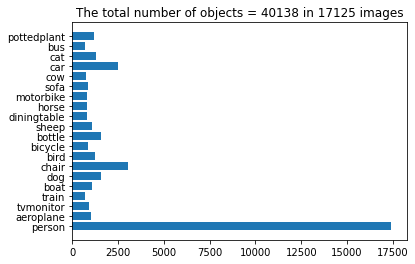

In [7]:
y_ticks = np.arange(len(class_counts))

plt.barh(y_ticks, list(class_counts.values()))

plt.yticks(y_ticks, list(class_counts.keys()))

plt.title("The total number of objects = {} in {} images".format(
    np.sum(list(class_counts.values())), len(all_anns)
))
plt.show()


V·ªõi m·ª•c ƒë√≠ch minh h·ªça thu·∫≠t to√°n, ta s·∫Ω ch·ªâ s·ª≠ d·ª•ng t·∫≠p training v√† validation:

In [8]:
all_anns = np.array(all_anns)

np.random.seed(666)
np.random.shuffle(all_anns)

ratio = 0.8

train_anns = all_anns[: int(0.8 * len(all_anns))]
val_anns = all_anns[int(0.8 * len(all_anns)):]

<a id='1'></a>
## 1. Anchor box clustering v·ªõi thu·∫≠t to√°n K-Means

T·ª´ c√°c nh∆∞·ª£c ƒëi·ªÉm m√¥ YOLOv1 nh∆∞ kh√¥ng d·ª± ƒëo√°n t·ªët nh·ªØng v·∫≠t th·ªÉ c√≥ k√≠ch th∆∞·ªõc kh√°c nhau ·ªü v√πng l√¢n c·∫≠n, YOLOv2 ƒë√£ s·ª≠ d·ª•ng c√°c anchor box (√Ω t∆∞·ªüng n√†y th·ª±c ch·∫•t ƒë∆∞·ª£c tham kh·∫£o t·ª´ c√°c thu·∫≠t to√°n RCNN).

T·∫°i m·ªói √¥ l∆∞·ªõi s·∫Ω c√≥ m·ªôt s·ªë l∆∞·ª£ng anchor box nh·∫•t ƒë·ªãnh, t·ª´ ƒë√≥ l√†m c∆° s·ªü ƒë·ªÉ d·ª± ƒëo√°n c√°c bounding box cho ƒë·ªëi t∆∞·ª£ng n√†o ƒë√≥. 

***V√≠ d·ª•***: S·ª≠ d·ª•ng anchor box c√≥ k√≠ch th∆∞·ªõc r·ªông + th·∫•p s·∫Ω c√≥ kh·∫£ nƒÉng x√°c ƒë·ªãnh ƒë∆∞·ª£c nh·ªØng v·∫≠t th·ªÉ d·∫°ng nh∆∞ chi·∫øc xe √¥ t√¥

Ta c·∫ßn x√°c ƒë·ªãnh tr∆∞·ªõc nh·ªØng si√™u tham s·ªë sau:
- S·ªë l∆∞·ª£ng anchor box
- K√≠ch th∆∞·ªõc c·ªßa c√°c anchor box

Ta kh√¥ng n√™n ch·ªçn "b·∫±ng tay" m√† c·∫ßn c√≥ m·ªôt ph∆∞∆°ng ph√°p ƒë·ªÉ ch·ªçn sao cho ph√π h·ª£p v·ªõi t·∫≠p d·ªØ li·ªáu ƒëang d√πng. Trong paper c·ªßa YOLOv2, c√°c t√°c gi·∫£ s·ª≠ d·ª•ng thu·∫≠t to√°n K-Means. Ta s·∫Ω ph√¢n c·ª•m c√°c bounding box c√≥ trong label, v·ªõi:
- S·ªë l∆∞·ª£ng c·ª•m = S·ªë l∆∞·ª£ng anchor box s·∫Ω d√πng cho YOLOv2
- M·ªói ph·∫ßn t·ª≠ l√† vector 2 chi·ªÅu, c√≥ √Ω nghƒ©a l√† (width, height) c·ªßa anchor box

ƒê·ªô ƒëo ƒë∆∞·ª£c s·ª≠ d·ª•ng l√† IOU gi·ªØa bounding box trong d·ªØ li·ªáu v√† t√¢m c·ªßa c√°c c·ª•m






#### L·∫•y ra gi√° tr·ªã width, height c·ªßa to√†n b·ªô bounding box trong t·∫≠p d·ªØ li·ªáu

Do k√≠ch th∆∞·ªõc c·ªßa c√°c ·∫£nh l√† kh√°c nhau n√™n ta s·∫Ω chu·∫©n h√≥a width, height c·ªßa c√°c bounding box trong ·∫£nh ƒë√≥ b·∫±ng c√°ch chia ch√∫ng cho width v√† height c·ªßa ·∫£nh

In [62]:
train_wh = []
for ann in train_anns:
    img_width = float(ann['width'])
    img_height = float(ann['height'])
    for obj in ann["object"]:
        # normalize
        w = (obj["xmax"] - obj["xmin"]) / img_width
        h = (obj["ymax"] - obj["ymin"]) / img_height
        train_wh.append([w, h])

train_wh = np.array(train_wh)
print(train_wh.shape)

(31979, 2)


#### T√≠nh IOU

Ta ch·ªâ d·ª±a v√†o c√°c th√¥ng tin width, height c·ªßa 2 box ƒë·ªÉ t√≠nh IOU, do ƒë√≥ ta xem ch√∫ng c√≥ chung ƒë·ªânh top-left.

In [9]:
def iou(box1, box2):
    '''
    Compute the IOU value of `box1` and `box2`
    Arguments:
        `box1` and `box2`: a numpy array of shape (2,), indicates [w, h]
    Return:
        IOU value
    '''
    x = np.minimum(box1[0], box2[0]) 
    y = np.minimum(box1[1], box2[1])

    intersection = x * y
    box1_area = box1[0] * box1[1]
    box2_area = box2[0] * box2[1]
    union = box1_area + box2_area - intersection

    return intersection / union

#### Thu·∫≠t to√°n K-Means

L∆∞u √Ω r·∫±ng ta s·∫Ω s·ª≠ d·ª•ng ƒë·ªô ƒëo IOU (thay v√¨ Euclid nh∆∞ b·∫£n g·ªëc) v√† ph√©p c·∫≠p nh·∫≠t clusters s·∫Ω d√πng median (thay v√¨ mean)

In [51]:
from sklearn.metrics import pairwise_distances

def isConverged(X_old, X_new):
    return set(tuple(X) for X in X_old) == set(tuple(X) for X in X_new)


def kmeans(boxes, n_cluster, seed=2022):
    '''
    K-means clustering with IOU metric.
    Arguments:
        `boxes`: a numpy array of shape (N, 2), indicates [w, h]
        `n_cluster`: the number of clusters
        `seed`: random seed
    Return:
        `clusters`: a numpy array of shape (`n_cluster`, 2)
        `labels`: a numpy array of shape (N, 1)
        `mean_distances`: the mean value of distances between each box and its cluster centroids
    '''
    n_box = len(boxes)
    np.random.seed(seed)

    # initialize the clusters
    clusters = boxes[np.random.choice(n_box, n_cluster, replace=False)]

    while True:
        # assign labels to each box
        distances = 1 - pairwise_distances(boxes, clusters, metric=iou)
        labels = np.argmin(distances, axis=1)

        # update clusters
        new_cluster = np.zeros((n_cluster, boxes.shape[1]))
        for i in range(n_cluster):
            new_cluster[i] = np.mean(boxes[labels == i], axis=0)

        if isConverged(clusters, new_cluster):
            break
        
        clusters = new_cluster

    mean_distances = np.mean(distances[np.arange(n_box), labels])
    return clusters, labels, mean_distances

Ch·∫°y K-Means v·ªõi gi√° tr·ªã k t·ª´ 2 ƒë·∫øn 8 ƒë·ªÉ t√¨m ra gi√° tr·ªã t·ªët nh·∫•t:

In [80]:
results = {}
for k in range(2, 9):
    clusters, labels, mean_dist = kmeans(train_wh, k)

    result = {"clusters": clusters,
              "labels": labels,
              "mean_dist":  mean_dist}

    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(
        k, 1 - mean_dist))

    results[k] = result


 2 clusters: mean IoU = 0.4649
 3 clusters: mean IoU = 0.5386
 4 clusters: mean IoU = 0.5800
 5 clusters: mean IoU = 0.6016
 6 clusters: mean IoU = 0.6221
 7 clusters: mean IoU = 0.6431
 8 clusters: mean IoU = 0.6578


Visualize k·∫øt qu·∫£ K-Means v√† ch·ªçn gi√° tr·ªã k v·ªõi ***Eblow method***

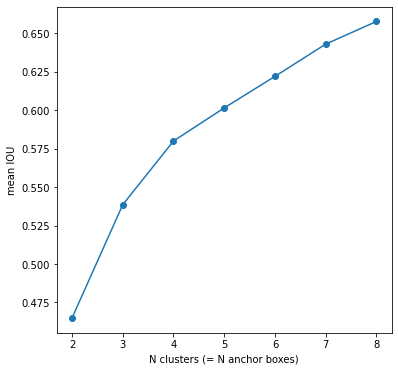

In [81]:
plt.figure(figsize=(6,6))

plt.plot(np.arange(2, 9),
         [1 - results[k]["mean_dist"] for k in range(2, 9)],"o-")

plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()

D·ª±a v√†o bi·ªÉu ƒë·ªì tr√™n, ta ch·ªçn **k = 4**

In [82]:
n_anchor_box = 4
results[n_anchor_box]["clusters"]

array([[0.08264212, 0.13575117],
       [0.41898774, 0.6221668 ],
       [0.80433065, 0.77523612],
       [0.20665115, 0.3896164 ]])

ƒê·ªÉ √Ω r·∫±ng:
- (0.08264212, 0.13575117) $\rightarrow$ anchor box r·∫•t nh·ªè
- (0.20665115, 0.3896164) $\rightarrow$ anchor box nh·ªè
- (0.41898774, 0.6221668) $\rightarrow$ anchor box v·ª´a
- (0.80433065, 0.77523612) $\rightarrow$ anchor box l·ªõn

C√°c gi√° tr·ªã n√†y s·∫Ω ƒë∆∞·ª£c ta s·ª≠ d·ª•ng trong c√°c ph·∫ßn ti·∫øp theo

In [10]:
ANCHORS = np.array([[0.08264212, 0.13575117],
                    [0.41898774, 0.6221668],
                    [0.80433065, 0.77523612],
                    [0.20665115, 0.3896164]])

## 2. X·ª≠ l√Ω Input v√† Label

### 2.1. Input encoding

V·ªõi m·ªói ·∫£nh ƒë·∫ßu v√†o, ta s·∫Ω resize n√≥ v·ªÅ 1 k√≠ch th∆∞·ªõc (416 x 416 ho·∫∑c 608 x 608). Khi ƒë√≥, c√°c t·ªça ƒë·ªô $x_{min}$, $x_{max}$, $y_{min}$, $y_{max}$ c·ªßa c√°c bounding box c≈©ng s·∫Ω ƒë∆∞·ª£c rescale theo.

***V√≠ d·ª•***: ·∫¢nh g·ªëc 600 x 800, t·ªça ƒë·ªô $x_{min}$ l√† 200. Ta resize ·∫£nh v·ªÅ 416 x 416. Khi ƒë√≥
$$ x_{min} \to \frac{x_{min}}{600} * 416$$

In [11]:
import copy

def normalize(image):
    return image / 255.

class ImageReader(object):
    def __init__(self, img_size=416, norm=normalize):
        '''
        Arguments:
            `img_size`: width and height of image (416 or 608)
            `norm`: normalization method
        '''
        self.img_size = img_size
        self.norm = norm

    def fit(self, img_ann):
        '''
        Arguments:
            `img_ann`: a dictionary contains the annotation of an image
        Return:
            `image`: cv2 image that is resized and normalized
            `all_obj`: a list of dictionarys about name and coordinates of objects
        '''
        img_name = img_ann['filename']

        image = cv2.imread(img_name)

        if image is None:
            print('Cannot find ', img_name)
            return

        img_h, img_w, img_c = image.shape

        # Resize and normalize the image
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image[:, :, ::-1]
        if self.norm:
            image = self.norm(image)

        # Rescale object coordinates
        if "object" in img_ann.keys():
            all_objs = copy.deepcopy(img_ann['object'])

            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.img_size) / img_w)
                    obj[attr] = max(min(obj[attr], self.img_size), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.img_size) / img_h)
                    obj[attr] = max(min(obj[attr], self.img_size), 0)
        else:
            return image

        return image, all_objs


Ch·∫°y th·ª≠ l·ªõp `ImageReader`

In [12]:
print("Input")
demo_image = train_anns[0]
for key, v in demo_image.items():
    print(f"  {key}: {v}")

print("Output")
inputEncoder = ImageReader(img_size=416, norm=normalize)
image, all_objs = inputEncoder.fit(demo_image)
print(f"  {all_objs}")

plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

Input
  object: [{'name': 'person', 'xmax': 287, 'xmin': 242, 'ymax': 220, 'ymin': 125}]
  filename: VOC2012/JPEGImages/2012_000169.jpg
  height: 375
  width: 500
Output
  [{'name': 'person', 'xmax': 238, 'xmin': 201, 'ymax': 244, 'ymin': 138}]


### 2.2. Label encoding

### 2.2.1. T·ª´ t·ªça ƒë·ªô pixel ƒë·∫øn t·ªça ƒë·ªô t∆∞∆°ng ƒë·ªëi
ƒê·ªëi v·ªõi c√°c thu·∫≠t to√°n YOLO, ta kh√¥ng s·ª≠ d·ª•ng c√°c t·ªça ƒë·ªô $x_{min}$, $x_{max}$, $y_{min}$, $y_{max}$ c·ªßa c√°c bounding box l√†m label m√† l√† $x_{center}, y_{center}, width, height$

YOLOv1 xem c√°c ƒë·ªânh top-left v√† bottom-right c·ªßa m·ªói √¥ l∆∞·ªõi t∆∞∆°ng ·ª©ng v·ªõi c√°c √¥ (0,0), (1,1). T·ª´ ƒë√≥, c√°c gi√° tr·ªã t·ªça ƒë·ªô t√¢m s·∫Ω ƒë∆∞·ª£c scale v·ªÅ trong c√°c √¥ l∆∞·ªõi ch·ª©a n√≥. Width v√† height th√¨ s·∫Ω chu·∫©n h√≥a v·ªÅ (0,1) d·ª±a theo k√≠ch th∆∞·ªõc ·∫£nh.

Trong phi√™n b·∫£n c√†i ƒë·∫∑t YOLOv2 n√†y, ƒë·ªÉ thu·∫≠n ti·ªán, ta s·∫Ω th·ª±c hi·ªán ph∆∞∆°ng ph√°p kh√°c nh∆∞ sau:
- Theo paper g·ªëc, ta s·ª≠ d·ª•ng l∆∞·ªõi 13 x 13 cho b·ª©c ·∫£nh size 416 ho·∫∑c 608
- Rescale c·∫£ 4 gi√° tr·ªã t·ªça ƒë·ªô x, y, width, height v·ªÅ [0,13]
    - ***V√≠ d·ª•***: Bounding box c√≥ width l√† 150 pixel. Khi ƒë√≥ ta rescale th√†nh $$\frac{150}{416} * 13 = 4.6875$$

In [13]:
def rescale_box(box, img_size=416, grid_size=13):
    '''
    Rescale the box coordinate to our method
    Arguments:
        `box`: an array of shape (4,), indicates [xmin, ymin, xmax, ymax] 
        `img_size`: width and height of image (416 or 608)
        `grid_size`: the number of grid cells on horizontal (or vertical)
    Return:
        `rescaled_box`: a numpy array of shape (4,)
    '''
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    rescaled_box = np.array([x, y, w, h])
    rescaled_box = rescaled_box * grid_size / img_size
    return rescaled_box

### 2.2.2. Label c·ªßa c√°c anchor box

K√≠ch th∆∞·ªõc c·ªßa input, output c·ªßa YOLOv2 nh∆∞ sau:
- Input: (IMG_SIZE, IMG_SIZE, 3)
- Output: (GRID_SIZE, GRID_SIZE, N_BOX, 4 + 1 + N_CLASS)

T·∫°i m·ªói √¥ l∆∞·ªõi, ta s·∫Ω c√≥ N_BOX anchor box. Khi ƒë√≥, n·∫øu trong √¥ l∆∞·ªõi ƒë√≥ c√≥ m·ªôt object A th√¨ trong c√°c anchor box n√†y c·∫ßn c√≥ 1 anchor box ch·ªãu tr√°ch nhi·ªám v·ªÅ A, t·ª©c l√† vector (4 + 1 + N_CLASS) chi·ªÅu t·∫°i ƒë√≥ s·∫Ω c√≥ gi√° tr·ªã gi·ªëng v·ªõi label c·ªßa object ƒë√≥ (c√≥ ƒë∆∞·ª£c t·ª´ c√°c annotation).

Ti√™u ch√≠ ch·ªçn ra anchor box ph√π h·ª£p s·∫Ω l√† t√≠nh IOU gi·ªØa anchor box ƒë√≥ v·ªõi bounding box c·ªßa object. H∆°n n·ªØa, ta s·∫Ω xem ch√∫ng c√≥ c√πng ƒë·ªânh top-left l√† (0, 0), vi·ªác t√≠nh IOU ch·ªâ c·∫ßn d·ª±a v√†o width v√† height.

T·ª´ ƒë√≥, ta x√¢y d·ª±ng l·ªõp `BestAnchorBoxFinder` nh∆∞ sau:

In [14]:
class BestAnchorBoxFinder:
    def __init__(self, ANCHORS):
        '''
        Arguments:
            `ANCHORS`: a np.array of shape (k, 2) of anchor boxes (found by K-Means)
        '''
        self.anchors = ANCHORS

    def find(self, w, h):
        '''
        Arguments:
            `w`, `h`: width and height of the bounding box
        '''
        best_anchor = -1
        max_iou = -1

        for i in range(len(self.anchors)):
            anchor = self.anchors[i]
            cur_iou = iou((w, h), anchor)
            if max_iou < cur_iou:
                best_anchor = i
                max_iou = cur_iou
                
        return best_anchor

## 3. L·ªõp MyGenerator

Ta s·∫Ω s·ª≠ d·ª•ng l·ªõp n√†y ƒë·ªÉ fetch d·ªØ li·ªáu theo t·ª´ng batch trong qu√° tr√¨nh training. C√°c ·∫£nh s·∫Ω ƒë∆∞·ª£c ƒë·ªçc trong m·ªói l·∫ßn fetch. ƒêi·ªÅu n√†y l√† c·∫ßn thi·∫øt v√¨ s·ªë l∆∞·ª£ng ·∫£nh r·∫•t l·ªõn (17125 ·∫£nh), RAM s·∫Ω kh√¥ng th·ªÉ ƒë·ªß ƒë·ªÉ ƒë·ªçc to√†n b·ªô ·∫£nh trong 1 l·∫ßn.

In [15]:
import tensorflow as tf

ƒê·ªÉ thu·∫≠n ti·ªán cho vi·ªác truy·ªÅn tham s·ªë v√†o h√†m kh·ªüi t·∫°o c·ªßa `MyGenerator`, ta s·ª≠ d·ª•ng dictionary `config` v·ªõi c√°c thu·ªôc t√≠nh sau:
- `IMG_SIZE`: 416 ho·∫∑c 608
- `GRID_SIZE`: s·ªë l∆∞·ª£ng √¥ l∆∞·ªõi tr√™n 1 h√†ng ho·∫∑c c·ªôt (v√≠ d·ª• nh∆∞ 13)
- `BATCH_SIZE`
- `CLASSES`: C√°c class m√† ta s·∫Ω train
- `ANCHORS`: m·∫£ng 2 chi·ªÅu, g·ªìm width v√† height c·ªßa c√°c anchor box ta t√¨m ƒë∆∞·ª£c b·∫±ng K-Means
- `TRUE_BOX_BUFFER`: V√¨ ***m·ªôt l√Ω do n√†o ƒë√≥*** m√† ngu·ªìn m√¨nh thao kh·∫£o s·ª≠ d·ª•ng th√™m tham s·ªë n√†y. ƒê√¢y l√† s·ªë l∆∞·ª£ng t·ªëi ƒëa c√°c bounding box trong m·ªôt ·∫£nh (d√πng cho vi·ªác t√≠nh loss, ta s·∫Ω ƒë·ªÅ c·∫≠p sau)

In [79]:
class MyGenerator(tf.keras.utils.Sequence):
    def __init__(self, anns, config, norm=normalize, shuffle=True):
        '''
        Arguments:
            `anns`: a list of dictionarys about information of each image, such as name and 
                    coordinates of objects
            `config` : dictionary containing necessary hyper parameters for traning.
        '''
        self.config = config
        self.n_abox = len(self.config['ANCHORS'])
        self.n_classes = len(self.config['CLASSES'])
        self.anns = anns
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_SIZE'], norm=norm)
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.anns)
            
    def __len__(self):
        return int(np.ceil(len(self.anns) / self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        '''
        Arguments:
            `idx`: the index of the batch
        
        Return:
            `x_batch`: a np.array of shape (batch_size, image_size, image_size, 3)
            `y_batch`: a np.array of shape (batch_size, grid_size, grid_size, BOX, 4 + 1 + n_class)
            `b_batch`: a np.array of shape (batch_size, 1, 1, 1, TRUE_BOX_BUFFER, 4)

        Note:
            `b_batch` will be used for calculate loss (?)
        '''

        left = idx * self.config['BATCH_SIZE']
        right = (idx + 1) * self.config['BATCH_SIZE']

        if right > len(self.anns):
            right = len(self.anns)
            left = right - self.config['BATCH_SIZE']

        cnt = 0
        
        x_batch = np.zeros((right - left, self.config['IMAGE_SIZE'], self.config['IMAGE_SIZE'], 3))
        b_batch = np.zeros((right - left, 1, 1, 1, self.config['TRUE_BOX_BUFFER'], 4))
        y_batch = np.zeros((right - left, self.config['GRID_SIZE'],  self.config['GRID_SIZE'], self.n_abox, 4 + 1 + self.n_classes))

        for ann in self.anns[left:right]:
            img, all_objs = self.imageReader.fit(ann)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if  obj['name'] in self.config['CLASSES']:
                    tmp = (obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'])
                    x_new, y_new, w_new, h_new = rescale_box(tmp, img_size=self.config['IMAGE_SIZE'], grid_size=self.config['GRID_SIZE'])
                    
                    grid_x = int(np.floor(x_new))
                    grid_y = int(np.floor(y_new))

                    if grid_x < self.config['GRID_SIZE'] and grid_y < self.config['GRID_SIZE']:
                        class_indx  = self.config['CLASSES'].index(obj['name'])
                        box = [x_new, y_new, w_new, h_new]
                        best_anchor = self.bestAnchorBoxFinder.find(w_new, h_new)

                        # assign the label to y_bacth
                        # coodinates
                        y_batch[cnt, grid_y, grid_x, best_anchor, 0:4] = box
                        # confidence
                        y_batch[cnt, grid_y, grid_x, best_anchor, 4] = 1.
                        # class probability
                        y_batch[cnt, grid_y, grid_x, best_anchor, 5 + class_indx] = 1
                        
                        # assign the true box to b_batch
                        b_batch[cnt, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[cnt] = img
            cnt += 1
        print('gen log')
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

Ch·∫°y th·ª≠ l·ªõp `MyGenerator`

In [17]:
demo_config = {
    'IMAGE_SIZE': 416,
    'GRID_SIZE': 13,
    'ANCHORS': ANCHORS,
    'CLASSES': CLASSES,
    'BATCH_SIZE': 32,
    'TRUE_BOX_BUFFER': 50,
}

In [18]:
demo_generator = MyGenerator(train_anns, demo_config, norm=normalize, shuffle=True)

In [19]:
[x_batch, b_batch], y_batch = demo_generator.__getitem__(idx=0)

In [20]:
print("x_batch = {}".format(x_batch.shape))
print("y_batch = {}".format(y_batch.shape))
print("b_batch = {}".format(b_batch.shape))

x_batch = (32, 416, 416, 3)
y_batch = (32, 13, 13, 4, 25)
b_batch = (32, 1, 1, 1, 50, 4)


Th·ª≠ visualize m·ªôt v√†i ·∫£nh c√πng v·ªõi bounding boxes

In [21]:
import copy

def demo_plot_img(idx):
    img = copy.deepcopy(x_batch[idx])
    img = np.pad(img, [(50,50), (50,50), (0,0)], mode='constant', constant_values=255)
    for grid_i in range(demo_config["GRID_SIZE"]):
        for grid_j in range(demo_config["GRID_SIZE"]):
            for anchor in range(len(demo_config["ANCHORS"])):
                vec = y_batch[idx, grid_i, grid_j, anchor, :]
                conf = vec[4]
                if conf == 1:
                    img_class = np.array(CLASSES)[np.where(vec[5:])][0]

                    x, y, w, h = vec[:4]
                    mult = demo_config["IMAGE_SIZE"] / demo_config["GRID_SIZE"]
                    xmin = int((x - 0.5 * w) * mult)
                    ymin = int((y - 0.5 * h) * mult)
                    xmax = int((x + 0.5 * w) * mult)
                    ymax = int((y + 0.5 * h) * mult)

                    cv2.rectangle(img, (xmin + 50, ymin + 50), (xmax + 50, ymax + 50),
                                  color=(0, 255, 0), thickness=3)
                    img = cv2.putText(img, text=str(img_class), org=(
                        xmin + 50, ymin - 5 + 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 0), thickness=3)

    plt.imshow(img)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


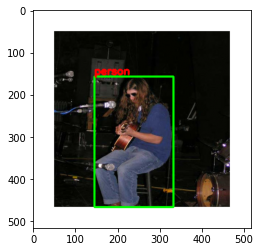

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


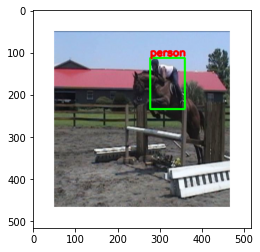

In [22]:
for i in range(4):
    demo_plot_img(i)

## 4. Ki·∫øn tr√∫c m√¥ h√¨nh

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Lambda, LeakyReLU
from tensorflow.keras.layers import Concatenate

ƒêi·ªÉm m·ªõi n·ªïi b·∫≠t nh·∫•t trong trong ki·∫øn tr√∫c YOLOv2 so v·ªõi YOLOv1 l√† s·ª≠ d·ª•ng c√°c t·∫ßng ***Batch Normalization***. Activation function d√πng cho c√°c t·∫ßng Convolution v·∫´n l√† ***Leaky ReLU***

In [24]:
def ConvBlock(x, filters, kernel_size, index, trainable=True):
    x = Conv2D(filters, kernel_size, padding='same', name='conv_' + str(index),
               trainable=trainable, use_bias=False)(x)
    x = BatchNormalization(name='norm_' + str(index))(x)
    x = LeakyReLU(alpha=0.1, name='leaky_' + str(index))(x)
    return x

V√¨ ta c·∫ßn c√†i ƒë·∫∑t nhi·ªÅu kh·ªëi `ConvBlock` li√™n ti·∫øp nhau n√™n ƒë·ªÉ thu·∫≠n ti·ªán th√¨ ta s·∫Ω vi·∫øt 1 h√†m h·ªó tr·ª£ ƒëi·ªÅu n√†y

In [25]:
def ConvBlock_stack(x, index, conv_stack, trainable):
    for param in conv_stack:
        x = ConvBlock(x, param["filters"], param["kernel_size"], index, trainable)
        index += 1
    return(x)

Ki·∫øn tr√∫c m√¥ h√¨nh:

***L∆∞u √Ω***: ƒê·ªëi v·ªõi Input, ngo√†i ·∫£nh th√¨ ta s·ª≠ d·ª•ng th√™m `true_boxes`. Vai tr√≤ c·ªßa n√≥ l√† ch·ª©a c√°c bounding box c·ªßa object c√≥ trong ·∫£nh. M·ª•c ƒë√≠ch c·ªßa ƒëi·ªÅu n√†y l√† s·ª≠ d·ª•ng cho h√†m loss (ta s·∫Ω ƒë·ªÅ c·∫≠p sau)

In [90]:
def YOLOv2(img_size, grid_size, true_box_buffer, n_abox, n_class, trainable=False):
    '''
    Arguments:
        `img_size`: The input image size in pixels (416 or 608)
        `grid_size`: The number of grid cells per input image (ex 13)
        `true_box_buffer`: the number of bounding box in an image (ex 50)
        `n_abox`: the number of anchor boxes
        `n_class`: the number of classes
        `trainable`: determine if the model is trainable
    '''

    # The number of filters and kernel_sizes of the convolution layers
    conv_stack_3_5 = [{"filters": 128, "kernel_size": (3, 3)},  # 3
                      {"filters": 64,  "kernel_size": (1, 1)},  # 4
                      {"filters": 128, "kernel_size": (3, 3)}]  # 5

    conv_stack_6_8 = [{"filters": 256, "kernel_size": (3, 3)},  # 6
                      {"filters": 128, "kernel_size": (1, 1)},  # 7
                      {"filters": 256, "kernel_size": (3, 3)}]  # 8

    conv_stack_9_13 = [{"filters": 512, "kernel_size": (3, 3)},  # 9
                       {"filters": 256, "kernel_size": (1, 1)},  # 10
                       {"filters": 512, "kernel_size": (3, 3)},  # 11
                       {"filters": 256, "kernel_size": (1, 1)},  # 12
                       {"filters": 512, "kernel_size": (3, 3)}]  # 13

    conv_stack_14_20 = [{"filters": 1024, "kernel_size": (3, 3)},  # 14
                        {"filters": 512,  "kernel_size": (1, 1)},  # 15
                        {"filters": 1024, "kernel_size": (3, 3)},  # 16
                        {"filters": 512,  "kernel_size": (1, 1)},  # 17
                        {"filters": 1024, "kernel_size": (3, 3)},  # 18
                        {"filters": 1024, "kernel_size": (3, 3)},  # 19
                        {"filters": 1024, "kernel_size": (3, 3)}]  # 20

    input_image = Input(shape=(img_size, img_size, 3), name="input_image")
    true_boxes = Input(shape=(1, 1, 1, true_box_buffer, 4), name="input_hack")

    # Layer 1
    x = ConvBlock(input_image, filters=32, kernel_size=(3, 3),
        index=1, trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2), name="maxpool1_416to208")(x)

    # Layer 2
    x = ConvBlock(x, filters=64, kernel_size=(3, 3),
        index=2, trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2), name="maxpool1_208to104")(x)

    # Layer 3 - 5
    x = ConvBlock_stack(x, index=3, conv_stack=conv_stack_3_5, trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2), name="maxpool1_104to52")(x)

    # Layer 6 - 8
    x = ConvBlock_stack(x, index=6, conv_stack=conv_stack_6_8, trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2), name="maxpool1_52to26")(x)

    # Layer 9 - 13
    x = ConvBlock_stack(x, index=9, conv_stack=conv_stack_9_13, trainable=trainable)

    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2), name="maxpool1_26to13")(x)

    # Layer 14 - 20
    x = ConvBlock_stack(x, index=14, conv_stack=conv_stack_14_20, trainable=trainable)

    # Layer 21
    skip_connection = ConvBlock(skip_connection, filters=64,
                                kernel_size=(1, 1), index=21, trainable=trainable)
    skip_connection = Lambda(lambda x: tf.nn.space_to_depth(x, block_size=2))(skip_connection)

    x = Concatenate()([skip_connection, x])

    # Layer 22
    x = ConvBlock(x, filters=1024, kernel_size=(3, 3), index=22, trainable=trainable)

    # Layer 23
    x = Conv2D(filters=n_abox * (4 + 1 + n_class), kernel_size=(1, 1), strides=(1, 1),
               padding='same', name='conv_23')(x)
    output = Reshape((grid_size, grid_size, n_abox, 4 + 1 + n_class),
                     name="final_output")(x)

    # small hack to allow true_boxes to be registered when Keras build the model
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0], name="hack_layer")(
        [output, true_boxes])

    model = Model([input_image, true_boxes], output)
    return model, true_boxes

Ta s·∫Ω kh√¥ng train ph·∫ßn backbone (22 layers ƒë·∫ßu ti√™n), do ƒë√≥ tham s·ªë `trainable` s·∫Ω l√† `False`

In [139]:
IMG_SIZE = 416
GRID_SIZE = 13
TRUE_BOX_BUFFER = 50
BATCH_SIZE = 32
N_ABOX = len(ANCHORS)
N_CLASS = len(CLASSES)

demo_model, demo_true_boxes = YOLOv2(IMG_SIZE, GRID_SIZE, TRUE_BOX_BUFFER, N_ABOX, N_CLASS, trainable=False)
demo_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_1 (LeakyReLU)             (None, 416, 416, 32) 0           norm_1[0][0]                     
____________________________________________________________________________________________

T·∫£i pre-trained weights cho backbone: https://pjreddie.com/media/files/yolov2.weights

In [34]:
weights_path = "./yolov2.weights"

Ta c·∫ßn g√°n gi√° tr·ªã weights n√†y cho 22 ConvBlock (c√°c layer `conv_i` v√† `norm_i`).

ƒê·∫ßu ti√™n l√† class `WeightReader` ƒë·ªÉ ƒë·ªçc c√°c gi√° tr·ªã t·ª´ file

In [27]:
class WeightReader:
    def __init__(self, weights_file):
        self.offset = 4
        self.all_weights = np.fromfile(weights_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[(self.offset - size):self.offset]
    
    def reset(self):
        self.offset = 4

Th·ª≠ ch·∫°y class `WeightReader`:

In [36]:
demo_weight_reader = WeightReader(weights_path)
print("all_weights.shape =", demo_weight_reader.all_weights.shape)

all_weights.shape = (50983565,)


H√†m g√°n weights cho c√°c layers:

In [28]:
def set_pretrained_weight(model, n_conv_block, weights_path):
    weight_reader = WeightReader(weights_path)
    weight_reader.reset()

    for i in range(1, n_conv_block + 1):
        conv_layer = model.get_layer('conv_' + str(i))

        # Don't set weights for norm_22 (?)
        if i < n_conv_block:
            norm_layer = model.get_layer('norm_' + str(i))

            size = np.prod(norm_layer.get_weights()[0].shape)

            beta = weight_reader.read_bytes(size)
            gamma = weight_reader.read_bytes(size)
            mean = weight_reader.read_bytes(size)
            var = weight_reader.read_bytes(size)

            norm_layer.set_weights([gamma, beta, mean, var])

        # If the conv_layer has biases:
        if len(conv_layer.get_weights()) > 1:
            bias = weight_reader.read_bytes(
                np.prod(conv_layer.get_weights()[1].shape))
            kernel = weight_reader.read_bytes(
                np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(
                list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2, 3, 1, 0])
            conv_layer.set_weights([kernel, bias])
        else:
            # Otherwise
            kernel = weight_reader.read_bytes(
                np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(
                list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2, 3, 1, 0])
            conv_layer.set_weights([kernel])
            
    return model


Ch·∫°y th·ª≠ h√†m `set_pretrained_weight`:

In [40]:
n_conv_block = 22
demo_model = set_pretrained_weight(demo_model, n_conv_block, weights_path)

Kh·ªüi t·∫°o tr·ªçng s·ªë cho layer 23 (layer convolution cu·ªëi c√πng)

In [29]:
def initialize_weight(layer, sd):
    weights = layer.get_weights()
    kernel = np.random.normal(size=weights[0].shape, scale=sd)
    bias = np.random.normal(size=weights[1].shape, scale=sd)
    layer.set_weights([kernel, bias])


Ch·∫°y th·ª≠ h√†m `initialize_weight`:

In [42]:
layer = demo_model.layers[-4]
initialize_weight(layer, sd=1/(GRID_SIZE*GRID_SIZE))

## 5. H√†m loss

***Sad:*** Trong paper c·ªßa YOLOv2, c√°c t√°c gi·∫£ kh√¥ng ƒë·ªÅ c·∫≠p c·ª• th·ªÉ v·ªÅ h√†m loss üò•

C√¥ng th·ª©c h√†m loss c·ªßa **YOLOv1** nh∆∞ sau:
$$ L = L_{confidence} + L_{localization} + L_{classification}$$
$$L_{confidence} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{obj} (C_i - \hat{C_i})^2 + \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{noobj} (C_i - \hat{C_i})^2 $$
$$L_{localization} = \lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{obj} \left [ (x_i - \hat{x_i})^2 + (y_i - \hat{y_i})^2  + (\sqrt{w_i} - \sqrt{\hat{w_i}})^2 + (\sqrt{h_i} - \sqrt{\hat{h_i}})^2 \right ] $$
$$L_{classification} = \sum_{i=0}^{S^2} \mathbb{I}_{i}^{obj} \sum_{c \in classes} (p_i(c) - \hat{p_i}(c))^2$$

V·ªõi **YOLOv2**, v·ªÅ c∆° b·∫£n, ta s·∫Ω s·ª≠ d·ª•ng c√¥ng th·ª©c t∆∞∆°ng t·ª± nh∆∞ tr√™n. Tuy nhi√™n, thay v√¨ ch·ªâ √°p d·ª•ng h√†m loss cho label v·ªõi 1 box t·∫°i m·ªói √¥ l∆∞·ªõi nh∆∞ YOLOv1, ta s·∫Ω √°p d·ª•ng cho t·∫•t c·∫£ c√°c anchor box. T·ª´ ƒë√≥, c√¥ng th·ª©c c√°c h√†m loss th√†nh ph·∫ßn c·ªßa ta nh∆∞ sau:
$$L_{confidence} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{obj} (C_{i,j} - \hat{C_{i,j}})^2 + \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{noobj} (C_{i,j} - \hat{C_{i,j}})^2 $$
$$L_{localization} = \lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{obj} \left [ (x_{i,j} - \hat{x_{i,j}})^2 + (y_{i,j} - \hat{y_{i,j}})^2  + (\sqrt{w_{i,j}} - \sqrt{\hat{w_{i,j}}})^2 + (\sqrt{h_{i,j}} - \sqrt{\hat{h_{i,j}}})^2 \right ] $$
$$L_{classification} = -\sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{i,j}^{obj} \sum_{c \in classes} (p_{i,j}^c \log \left ( \hat{p}_{i,j}^c \right ))$$

Trong ƒë√≥:
- $i$ ch·ªâ √¥ l∆∞·ªõi th·ª© $i$, $j$ ch·ªâ anchor box th·ª© $j$ trong √¥ l∆∞·ªõi ƒë√≥
- $x_{i,j}$ v√† c√°c gi√° tr·ªã t·ªça ƒë·ªô t√¢m kh√°c c≈©ng l√† ***ƒë·ªô d·ªùi t∆∞∆°ng ƒë·ªëi*** nh∆∞ YOLOv1
- $C_{i,j}$ l√† IOU gi·ªØa label c·ªßa anchor box th·ª© $j$ c·ªßa √¥ l∆∞·ªõi $i$ v√† gi√° tr·ªã d·ª± ƒëo√°n c·ªßa n√≥
- ƒê·ªëi v·ªõi loss ph√¢n lo·∫°i, ta s·∫Ω s·ª≠ d·ª•ng h√†m cross-entropy

***L∆∞u √Ω***: Output cho m·ªói anchor box l√† vector c√≥ chi·ªÅu $4 + 1 + n_{classes}$

### 5.1. Chu·∫©n h√≥a l·∫°i gi√° tr·ªã output

V√¨ layer 23 (layer cu·ªëi c√πng) c·ªßa m√¥ h√¨nh s·ª≠ d·ª•ng activation function tuy·∫øn t√≠nh n√™n ta c·∫ßn chu·∫©n h√≥a c√°c gi√° tr·ªã ƒë√≥. Theo paper g·ªëc, ta chu·∫©n h√≥a nh∆∞ sau:

<img src="./bbox_adjust.jpg"/>

Trong ƒë√≥
- C√°c gi√° tr·ªã output c·ªßa m√¥ h√¨nh l√† $t_x, t_y, t_w, t_h$
- Ngo√†i ra, gi√° tr·ªã confidence v√† x√°c su·∫•t c·ªßa c√°c class c≈©ng c·∫ßn ƒë·∫£m b·∫£o thu·ªôc [0, 1]. Ta s·∫Ω √°p d·ª•ng ***sigmoid*** cho confidence v√† ***softmax*** cho x√°c su·∫•t c·ªßa c√°c class

ƒê·∫ßu ti√™n, ta c·∫ßn t·∫°o ra 2 b·∫£ng `board_x`, `board_y` t∆∞∆°ng t·ª± nh∆∞ sau:
```python
board_x = [[0, 1, 2, 3]
           [0, 1, 2, 3]
           [0, 1, 2, 3]
           [0, 1, 2, 3]]
board_y = [[0, 0, 0, 0]
           [1, 1, 1, 1]
           [2, 2, 2, 2]
           [3, 3, 3, 3]]
```
ƒê·ªìng th·ªùi, ta s·∫Ω stack 2 b·∫£ng l·∫°i v·ªõi nhau --> (GRID_SIZE, GRID_SIZE, N_BOX, 2)

In [30]:
def board_coords(grid_size, batch_size, n_abox):
# def board_coords(grid_size):
    '''
    Arguments:
        `grid_size`: the number of grid cells in horizontal (or vertical)
    Return:
        `full_board`: Tensor of shape (1, grid_size, grid_size, 1, 2)
    '''
    board_x = tf.reshape(tf.tile(tf.range(grid_size), [
                         grid_size]), (1, grid_size, grid_size, 1, 1))
    board_y = tf.transpose(board_x, (0, 2, 1, 3, 4))
    full_board = tf.concat([board_x, board_y], axis=-1)
    full_board = tf.tile(full_board, [batch_size, 1, 1, n_abox, 1])
    return tf.cast(full_board, tf.float32)


H√†m chu·∫©n h√≥a gi√° tr·ªã output:

In [31]:
def adjust_scale_prediction(y_pred, full_board, ANCHORS):
    """
    Arguments:
        `y_pred`: A tensor of shape (batch_size, grid_size, grid_size, n_abox, 4 + 1 + n_class)
        `full_board`: A tensor of shape (batch_size, grid_size, grid_size, n_abox, 2)
        `ANCHORS`: A list of anchor boxes
    """
    n_abox = len(ANCHORS)

    # Use sigmoid function
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + full_board

    # Use exp function
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1, 1, 1, n_abox, 2])

    # Confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])

    # Class probabilities
    pred_box_class = y_pred[..., 5:]

    return pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class


### 5.2. Tr√≠ch xu·∫•t label

In [32]:
def extract_label(label):
    '''
    Arguments:
        `label`: A tensor of shape (batch_size, grid_size, grid_size, n_abox, 4 + 1 + n_class)
    Return:
        `true_box_xy`, `true_box_wh`, `true_box_conf`, `true_box_class`
    '''
    true_box_xy = label[..., 0:2]
    true_box_wh = label[..., 2:4]
    true_box_conf = label[..., 4]
    true_box_class = tf.argmax(label[..., 5:], -1)
    return true_box_xy, true_box_wh, true_box_conf, true_box_class

### 5.3. T√≠nh localization loss

Gi√° tr·ªã `mask` trong h√†m b√™n d∆∞·ªõi ch√≠nh l√† $\mathbb{I}_{ij}^{obj}$ trong c√¥ng th·ª©c c·ªßa ph·∫ßn loss n√†y

In [33]:
def localize_loss(true_box_conf, n_coord, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh):
    '''
    Arguments:
        `true_box_conf`: shape (batch_size, grid_size, grid_size, n_abox, 1)
        `n_coord`: lambda of localization loss
        `true_box_xy`, `pred_box_xy`, `true_box_wh`, `pred_box_wh`:
            shape (batch_size, grid_size, grid_size, n_abox, 2)
    Return:
        `loss`: localization loss
    '''
    mask = tf.expand_dims(true_box_conf, axis=-1) * n_coord
    #   --> (batch_size, grid_size, grid_size, n_abox, 2)

    # The number of object in this batch
    n_coord_box = tf.reduce_sum(tf.cast(mask > 0.0, tf.float32))

    loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * mask)
    loss_xy = loss_xy  / (n_coord_box + 1e-6) / 2.

    loss_wh = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * mask)
    loss_wh = loss_wh  / (n_coord_box + 1e-6) / 2.

    loss = loss_xy + loss_wh
    return loss


### 5.4. T√≠nh classification loss

T∆∞∆°ng t·ª± nh∆∞ tr√™n, gi√° tr·ªã `mask` trong h√†m b√™n d∆∞·ªõi c≈©ng ch√≠nh l√† $\mathbb{I}_{ij}^{obj}$ trong c√¥ng th·ª©c c·ªßa ph·∫ßn loss n√†y

In [52]:
def class_loss(true_box_conf, true_box_class, pred_box_class):
    '''
    Arguments:
        `true_box_conf`: shape (batch_size, grid_size, grid_size, n_abox, 1)
        `n_coord`: lambda of localization loss
        `true_box_class`: shape (batch_size, grid_size, grid_size, n_abox)
        `pred_box_class`: shape (batch_size, grid_size, grid_size, n_abox, n_class)     
    Return:
        `loss`: classification loss
    '''   
    mask = true_box_conf
    n_class_box = tf.reduce_sum(tf.cast(mask > 0.0, tf.float32))
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, 
                                                          logits=pred_box_class)
    loss = tf.reduce_sum(loss * mask) / (n_class_box + 1e-6)   
    return loss


### 5.5. T√≠nh confidence loss

ƒê·∫ßu ti√™n, ta c·∫ßn vi·∫øt h√†m t√≠nh IOU gi·ªØa bounding box d·ª± ƒëo√°n v√† label (h√†m n√†y kh√¥ng gi·ªëng nh∆∞ h√†m IOU ·ªü ph·∫ßn ƒë·∫ßu v√¨ n√≥ kh√¥ng ƒë∆∞a 2 box v·ªÅ c√πng ƒë·ªânh top-left)

In [35]:
def iou_general(true_xy, true_wh, pred_xy,pred_wh):
    '''
    Arguments:
        `true_xy`: shape (batch_size, grid_size, grid_size, n_abox, 2)
        Similar to `pred_xy`, `true_wh`, `pred_wh`

    Note: the shape of arguments might be different but they must have the same shape length
    (ex using broadcasting)
    '''
    true_mins    = true_xy - true_wh / 2.0
    true_maxes   = true_xy + true_wh / 2.0

    pred_mins    = pred_xy - pred_wh / 2.0
    pred_maxes   = pred_xy + pred_wh / 2.0    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    union_areas = pred_areas + true_areas - intersect_areas

    iou_scores  = intersect_areas / union_areas

    return iou_scores

Gi√° tr·ªã $C_{i,j}$ trong c√¥ng th·ª©c h√†m loss:
- B·∫±ng IOU gi·ªØa label c·ªßa anchor box th·ª© $j$ t·∫°i √¥ l∆∞·ªõi $i$ v√† gi√° tr·ªã d·ª± ƒëo√°n c·ªßa n√≥ n·∫øu true_conf c·ªßa anchox box n√†y l√† 1
- Ng∆∞·ª£c l·∫°i, 0

In [36]:
def iou_Cij(true_box_conf, true_box_xy, true_box_wh, pred_box_xy,  pred_box_wh):
    '''
    Arguments:
        `true_box_conf`: shape (batch_size, grid_size, grid_size, n_abox, 1)
        `true_box_xy`, `true_box_wh`, `pred_box_xy`, `pred_box_wh`:
            shape (batch_size, grid_size, grid_size, n_abox, 2)
    Return:
        `true_box_IOU`: shape (batch_size, grid_size, grid_size, n_abox)
    '''
    iou_scores = iou_general(true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return true_box_conf_IOU


ƒê·ªëi v·ªõi confidence loss, ta c·∫ßn ch√∫ √Ω ƒë·∫øn c√°c gi√° tr·ªã $\mathbb{I}_{ij}^{obj}$ v√† $\mathbb{I}_{ij}^{noobj}$:
- $\mathbb{I}_{ij}^{obj}$ l√† `true_box_conf` nh∆∞ nh·ªØng ph·∫ßn loss tr∆∞·ªõc
- Trong khi ƒë√≥
$$\mathbb{I}_{ij}^{noobj} = \left\{\begin{matrix}
1 \text{ n·∫øu } \underset{i',j'}{\max}\;IOU_{i,j \text{ predicted}}^{i', j' \text{ true boxes}} < 0.6 \text{ v√† } C_{i,j}=0 \\
\\
0 \text{ else}
\end{matrix}\right.$$

Do ƒë√≥, ta c·∫ßn t√≠nh xem v·ªõi m·ªói anchor box $j$ t·∫°i √¥ l∆∞·ªõi $i$, gi√° tr·ªã IOU l·ªõn nh·∫•t c·ªßa n√≥ v·ªõi 1 bounding box n√†o ƒë√≥ trong ·∫£nh l√† bao nhi√™u.

***·∫¢o:*** ƒê√¢y l√† l√Ω do ta ƒë√£ l∆∞u th√™m `b_batch` v√† gi√° tr·ªã `TRUE_BOX_BUFFER` ·ªü ph·∫ßn x√¢y d·ª±ng l·ªõp `MyGenerator`

In [67]:
def find_best_ious(pred_xy, pred_wh, true_boxes):
    '''
    Arguments:
        `pred_xy`, `pred_wh`:
            shape (batch_size, grid_size, grid_size, n_abox, 2)
        `true_boxes`: shape (batch_size, 1, 1, 1, TRUE_BOX_BUFFER, 4)
    Return:
        `best_ious`: shape (batch_size, grid_size, grid_size, n_abox)
    '''
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]

    # Expand pred_xy and pred_wh to (batch_size, grid_size, grid_size, n_abox, 1, 2)
    pred_xy_new = tf.expand_dims(pred_xy, 4)
    pred_wh_new = tf.expand_dims(pred_wh, 4)

    iou_scores = iou_general(true_xy, true_wh, pred_xy_new, pred_wh_new)
    # ---> (batch_size, grid_size, grid_size, n_abox, TRUE_BOX_BUFFER)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    return best_ious

H√†m t√≠nh confidence loss:

In [96]:
def conf_loss(true_box_conf, pred_box_conf, n_noobj, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh, true_boxes):
    '''
    Arguments:
        `true_box_conf` and `pred_box_conf`:
            shape (batch_size, grid_size, grid_size, n_abox)
        `n_noobj`: lambda of confidence loss (no object part)
        `true_box_xy`, `true_box_wh`, `pred_box_xy`, `pred_box_wh`:
            shape (batch_size, grid_size, grid_size, n_abox, 2)
        `true_boxes`: shape (batch_size, 1, 1, 1, TRUE_BOX_BUFFER, 4)
    Return:
        `loss`: confidence loss
    '''
    # Compute Cij
    true_box_conf_IOU = iou_Cij(true_box_conf, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
    
    # Find best iou for each anchor box
    best_ious = find_best_ious(pred_box_xy, pred_box_wh, true_boxes)

    # Confidence mask: object part and no object part
    conf_mask = (tf.cast(best_ious < 0.6, tf.float32) * true_box_conf) * n_noobj
    conf_mask = conf_mask + true_box_conf

    # "Mean" over batch
    n_conf_box = tf.reduce_sum(tf.cast(conf_mask > 0.0, tf.float32))

    # Loss
    loss = tf.reduce_sum(tf.square(true_box_conf_IOU - pred_box_conf) * conf_mask)  / (n_conf_box  + 1e-6) / 2.
    
    return loss


### 5.6. H√†m t√≠nh loss c·ªßa m√¥ h√¨nh

In [39]:
N_NOOBJ = 1.0
N_COORD = 5.0

In [91]:
# def final_loss(y_true, y_pred, n_coord, n_noobj, grid_size, ANCHORS, true_boxes):
#     '''
#     Arguments:
#         `y_true`, `y_pred: shape (batch_size, grid_size, grid_size, n_abox, 4 + 1 + n_classes)
#         `n_coord`: lambda of coordinate loss
#         `n_noobj`: lambda of confidence loss (no object part)
#         `grid_size`: grid size
#         `ANCHORS`: list of anchor boxes
#         `true_boxes`: shape (batch_size, 1, 1, 1, TRUE_BOX_BUFFER, 4)
#     '''
#     batch_size = y_true.shape[0]
#     n_abox = y_true.shape[3]
#     full_board = board_coords(grid_size)
#     full_board = tf.tile(full_board, [batch_size, 1, 1, n_abox, 1])

#     # Extract and scale y_ped
#     pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred, full_board, ANCHORS)

#     # Extract and scale y_true
#     true_box_xy, true_box_wh, true_box_conf, true_box_class = adjust_scale_prediction(y_true, full_board, ANCHORS)

#     # Compute the loss
#     loss = 0
#     loss += class_loss(true_box_conf, true_box_class, pred_box_class)
#     loss += localize_loss(true_box_conf, n_coord, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
#     loss += conf_loss(true_box_conf, pred_box_conf, n_noobj, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh, true_boxes)
#     return loss

In [109]:
def yolo_loss(y_true, y_pred):
    '''
    Arguments:
        `y_true` and `y_pred: shape (batch_size, grid_size, grid_size, n_abox, 4 + 1 + n_class)
    Return:
        `loss`: loss of the model over current batch
    '''
    # batch_size = tf.shape(y_true)[0]
    # n_abox = tf.shape(y_true)[3]
    # full_board = board_coords(GRID_SIZE)
    # full_board = tf.tile(full_board, [BATCH_SIZE, 1, 1, N_ABOX, 1])
    full_board = board_coords(GRID_SIZE, BATCH_SIZE, N_ABOX)
    # Extract and scale y_ped
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred, full_board, ANCHORS)

    # Extract and scale y_true
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_label(y_true)

    # Compute the loss
    loss1 = class_loss(true_box_conf, true_box_class, pred_box_class)
    loss2 = localize_loss(true_box_conf, N_COORD, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
    loss3 = conf_loss(true_box_conf, pred_box_conf, N_NOOBJ, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh, true_boxes)
    
    loss = loss1 + loss2 + loss3
    print('loss log')
    # print(loss.numpy())

    return loss

Trong c√†i ƒë·∫∑t c·ªßa h√†m `yolo_loss`, ta kh√¥ng h·ªÅ truy·ªÅn tham s·ªë `true_boxes`. L√†m th·∫ø n√†o m√† ch∆∞∆°ng tr√¨nh c√≥ th·ªÉ bi·∫øt ƒë∆∞·ª£c n√≥ l√† g√¨?

Quay l·∫°i ph·∫ßn ƒë·ªãnh nghƒ©a h√†m, ta ƒë√£ c√†i ƒë·∫∑t input c·ªßa m√¥ h√¨nh bao g·ªìm c·∫£ ·∫£nh v√† true_boxes c·ªßa ·∫£nh ƒë√≥, ƒëi·ªÅu n√†y s·∫Ω ƒë∆∞a true_boxes v√†o ƒë·ªì th·ªã t√≠nh to√°n c·ªßa Tensorflow, do ƒë√≥ ta c√≥ th·ªÉ l√†m ƒë∆∞·ª£c ƒëi·ªÅu tr√™n.

## 6. Training

Ta s·∫Ω gi·∫£i ph√≥ng b·ªô nh·ªõ cho nh·ªØng bi·∫øn ƒë√£ t·∫°o ·ªü ph√≠a tr√™n, v√¨ n√≥ ch·ªâ mang t√≠nh minh h·ªça

In [41]:
demo_model = None
demo_generator = None
demo_true_boxes = None
demo_weight_reader = None
input_batch = None
x_batch = None
b_batch = None
y_batch = None

Thi·∫øt l·∫≠p c√°c tham s·ªë:

In [42]:
ANCHORS = np.array([[0.08264212, 0.13575117],
                    [0.41898774, 0.6221668],
                    [0.80433065, 0.77523612],
                    [0.20665115, 0.3896164]])
                    
CLASSES = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle',
           'bus',        'car',      'cat',  'chair',     'cow',
           'diningtable', 'dog',    'horse',  'motorbike', 'person',
           'pottedplant', 'sheep',  'sofa',   'train',   'tvmonitor']

In [43]:
BATCH_SIZE = 32
IMG_SIZE = 416
GRID_SIZE = 13
TRUE_BOX_BUFFER = 50
N_CLASS = len(CLASSES)
N_ABOX = len(ANCHORS)
N_NOOBJ = 1.0
N_COORD = 5.0

config = {
    'IMAGE_SIZE': 416,
    'GRID_SIZE': 13,
    'CLASSES': CLASSES,
    'ANCHORS': ANCHORS,
    'BATCH_SIZE': BATCH_SIZE,
    'TRUE_BOX_BUFFER': TRUE_BOX_BUFFER,
}

T·∫°o Generator cho trainig v√† testing:

In [97]:
train_generator = MyGenerator(train_anns, config, norm=normalize, shuffle=True)
val_generator = MyGenerator(val_anns, config, norm=normalize, shuffle=True)

ƒê·ªãnh nghƒ©a m√¥ h√¨nh:

In [98]:
model, true_boxes = YOLOv2(IMG_SIZE, GRID_SIZE, TRUE_BOX_BUFFER, N_ABOX, N_CLASS, trainable=False)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_1 (LeakyReLU)             (None, 416, 416, 32) 0           norm_1[0][0]                     
____________________________________________________________________________________________

Kh·ªüi t·∫°o tr·ªçng s·ªë cho m√¥ h√¨nh:

In [99]:
weights_path = './yolov2.weights'
n_conv_block = 22
model = set_pretrained_weight(model, n_conv_block, weights_path)
layer = model.layers[-4]  # the last convolutional layer
initialize_weight(layer, sd=1/(GRID_SIZE*GRID_SIZE))

Bi√™n d·ªãch m√¥ h√¨nh:

In [74]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [116]:
optimizer = Adam(lr=1e-4)
model.compile(loss=yolo_loss, optimizer=optimizer, experimental_run_tf_function=False)

Early Stopping v√† Checkpoint:

In [101]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [102]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.001,
                           patience=5,
                           mode='min')

checkpoint = ModelCheckpoint('train_weights.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

Train th√¥i!

In [120]:
model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stop, checkpoint])

ValueError: Calling `Model.fit` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.fit` with eager mode enabled.